In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix



# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,models,Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


print(tf.__version__)

2.14.0


# Loading Dataset

In [2]:
#importing kaggle.json file for kaggle connection

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sayedanwar222","key":"d9eea4181d8f32179aa8a4218269394d"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download ryanpartridge01/wild-edible-plants

 99% 1.69G/1.70G [00:20<00:00, 122MB/s]
100% 1.70G/1.70G [00:20<00:00, 89.8MB/s]


In [5]:
!unzip -qq /content/wild-edible-plants.zip

In [6]:
dataset = {
             "train_data" : "/content/dataset/resized",
            # "test_data" : "/content/datasets/dataset-test"
          }

all_data = []
for path in dataset.values():
    data = {"imgpath": [] , "labels": [] }
    category = os.listdir(path)

    for folder in category:
        folderpath = os.path.join(path , folder)
        filelist = os.listdir(folderpath)
        for file in filelist:
            fpath = os.path.join(folderpath, file)
            data["imgpath"].append(fpath)
            data["labels"].append(folder)


    all_data.append(data.copy())
    data.clear()



train_df = pd.DataFrame(all_data[0] , index=range(len(all_data[0]['imgpath'])))
#test_df = pd.DataFrame(all_data[1] , index=range(len(all_data[1]['imgpath'])))


# #Convert labels to numbers
lb = LabelEncoder()
train_df['encoded_labels'] = lb.fit_transform(train_df['labels'])
#test_df['encoded_labels'] = lb.fit_transform(test_df['labels'])



In [7]:
train_df , test_df = train_test_split(train_df ,  train_size= 0.80 , shuffle=True, random_state=124)
test_df , valid_df = train_test_split(train_df ,  train_size= 0.50 , shuffle=True, random_state=124)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


# Traing Data images count per class

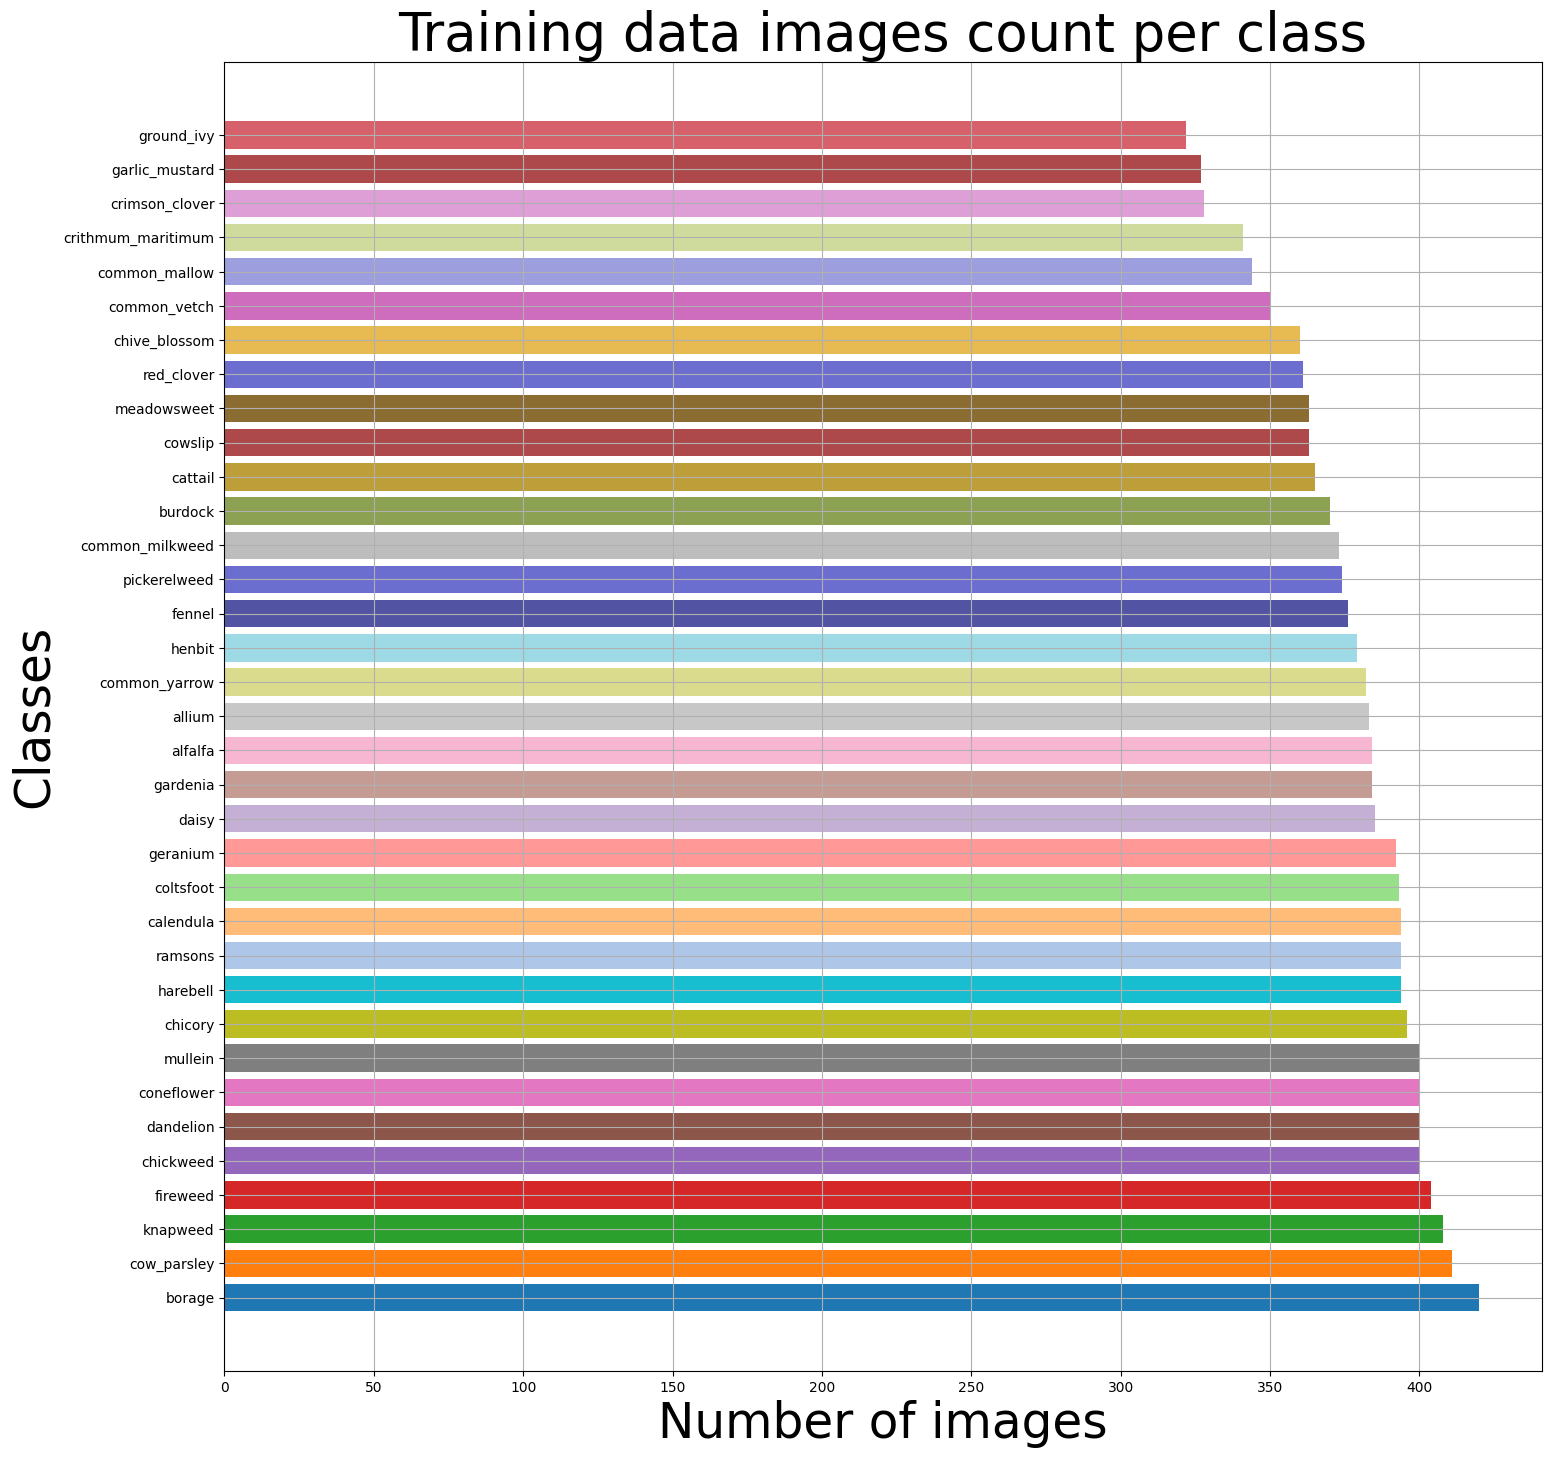

In [8]:

train  = train_df["labels"].value_counts()
label = train.tolist()
index = train.index.tolist()

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
    "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
    "#5254a3", "#6b6ecf", "#bdbdbd", "#8ca252", "#bd9e39",
    "#ad494a", "#8c6d31", "#6b6ecf", "#e7ba52", "#ce6dbd",
    "#9c9ede", "#cedb9c", "#de9ed6", "#ad494a", "#d6616b",
    "#f7f7f7", "#7b4173", "#a55194", "#ce6dbd"
]



plt.figure(figsize=(17,17))
plt.title("Training data images count per class",fontsize=38)
plt.xlabel('Number of images', fontsize=35)
plt.ylabel('Classes', fontsize=35)
plt.barh(index,label, color=colors)
plt.grid(True)
plt.show()

In [9]:
train_df.sample(n=15, random_state=1)

imgpath          labels  \
16341    /content/dataset/resized/ramsons/ramsons430.jpg         ramsons   
10483    /content/dataset/resized/mullein/mullein266.jpg         mullein   
2665   /content/dataset/resized/cow_parsley/cow_parsl...     cow_parsley   
5644   /content/dataset/resized/garlic_mustard/garlic...  garlic_mustard   
11525  /content/dataset/resized/calendula/calendula34...       calendula   
2802   /content/dataset/resized/cow_parsley/cow_parsl...     cow_parsley   
9670     /content/dataset/resized/cowslip/cowslip290.jpg         cowslip   
2490   /content/dataset/resized/cow_parsley/cow_parsl...     cow_parsley   
5149   /content/dataset/resized/chickweed/chickweed12...       chickweed   
5013   /content/dataset/resized/chickweed/chickweed21...       chickweed   
1202       /content/dataset/resized/borage/borage209.jpg          borage   
8008   /content/dataset/resized/fireweed/fireweed149.jpg        fireweed   
3393   /content/dataset/resized/knapweed/knapweed334.jpg        knapweed   
4672   /content/dataset/resized/harebell/harebell288.jpg        harebell   
873      /content/dataset/resized/burdock/burdock427.jpg         burdock   

       encoded_labels  
16341              33  
10483              31  
2665               15  
5644               24  
11525               4  
2802               15  
9670               16  
2490               15  
5149                6  
5013                6  
1202                2  
8008               22  
3393               29  
4672               27  
873                 3

In [10]:
print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imgpath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                                 imgpath              labels
14440    /content/dataset/resized/chicory/chicory476.jpg             chicory
1310       /content/dataset/resized/borage/borage409.jpg              borage
8699   /content/dataset/resized/coltsfoot/coltsfoot22...           coltsfoot
5765   /content/dataset/resized/crithmum_maritimum/cr...  crithmum_maritimum
10273    /content/dataset/resized/mullein/mullein142.jpg             mullein
(13220, 3)
--------Validation----------
                                             imgpath              labels
0  /content/dataset/resized/crithmum_maritimum/cr...  crithmum_maritimum
1  /content/dataset/resized/calendula/calendula46...           calendula
2    /content/dataset/resized/mullein/mullein213.jpg             mullein
3  /content/dataset/resized/chickweed/chickweed26...           chickweed
4  /content/dataset/resized/ground_ivy/ground_ivy...          ground_ivy
(6610, 3)
----------Test-------

# Show sample from data

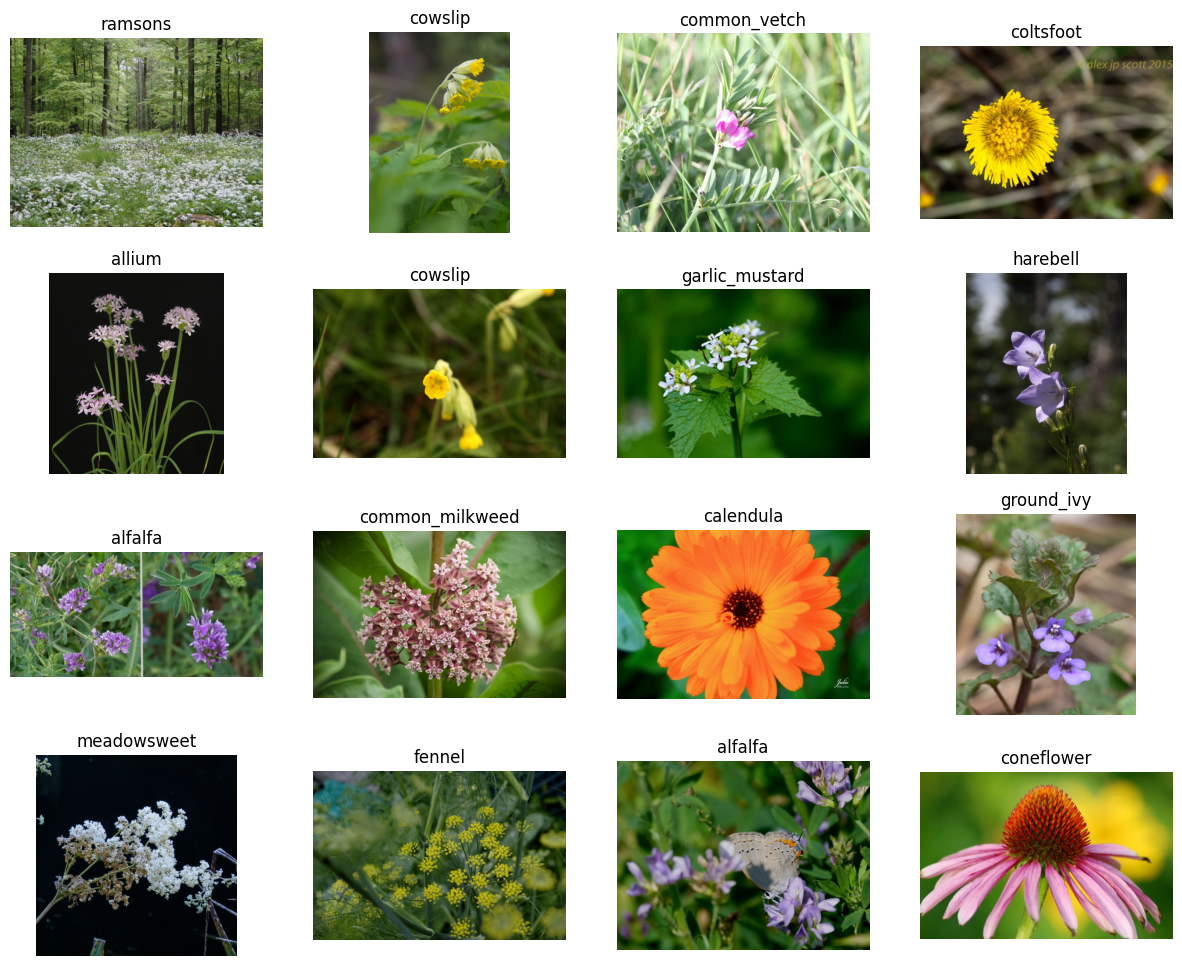

In [11]:
plt.figure(figsize=(15,12))
for i, row in valid_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

# Creating Dataloaders

In [12]:
%%time

BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)


generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    # there could be image augmentation here
)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 13220 validated image filenames belonging to 35 classes.
Found 6610 validated image filenames belonging to 35 classes.
Found 6610 validated image filenames belonging to 35 classes.
CPU times: user 229 ms, sys: 81.9 ms, total: 311 ms
Wall time: 328 ms


# Model Structure

In [13]:
# Load the pretained model
pretrained_model = tf.keras.applications.EfficientNetB5(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = True
for layer in pretrained_model.layers:
    if isinstance(layer, layers.BatchNormalization): # set BatchNorm layers as not trainable
        layer.trainable = False

# let`s see first 10 layers
for l in pretrained_model.layers[:10]:
    print(l.name, l.trainable)

115263384/115263384 [==============================] - 1s 0us/step
input_1 True
rescaling True
normalization True
rescaling_1 True
stem_conv_pad True
stem_conv True
stem_bn False
stem_activation True
block1a_dwconv True
block1a_bn False


# Training : Transfer Learning

In [14]:
num_classes = len(set(train_images.classes))


# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
], name='AugmentationLayer')



inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = augment(inputs)
pretrain_out = pretrained_model(x, training = False)
x = layers.Dense(256)(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)



model.compile(
    optimizer=Adam(0.00001), # fine tuning requires very little learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 efficientnetb5 (Functional  (None, 2048)              28513527  
 )                                                               
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024  

In [15]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True), # if val loss decreases for 5 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model.save_weights('./checkpoints/my_checkpoint')

Epoch 1/50
414/414 [==============================] - 288s 478ms/step - loss: 2.8499 - accuracy: 0.2637 - val_loss: 1.5959 - val_accuracy: 0.5750 - lr: 1.0000e-05
Epoch 2/50
414/414 [==============================] - 193s 465ms/step - loss: 1.4416 - accuracy: 0.5994 - val_loss: 0.9193 - val_accuracy: 0.7697 - lr: 1.0000e-05
Epoch 3/50
414/414 [==============================] - 192s 463ms/step - loss: 0.9169 - accuracy: 0.7551 - val_loss: 0.6315 - val_accuracy: 0.8324 - lr: 1.0000e-05
Epoch 4/50
414/414 [==============================] - 192s 463ms/step - loss: 0.6584 - accuracy: 0.8256 - val_loss: 0.4523 - val_accuracy: 0.8805 - lr: 1.0000e-05
Epoch 5/50
414/414 [==============================] - 190s 460ms/step - loss: 0.5022 - accuracy: 0.8680 - val_loss: 0.3645 - val_accuracy: 0.9015 - lr: 1.0000e-05
Epoch 6/50
414/414 [==============================] - 192s 463ms/step - loss: 0.4051 - accuracy: 0.8918 - val_loss: 0.3119 - val_accuracy: 0.9145 - lr: 1.0000e-05
Epoch 7/50
414/414 [==

# Display model performance

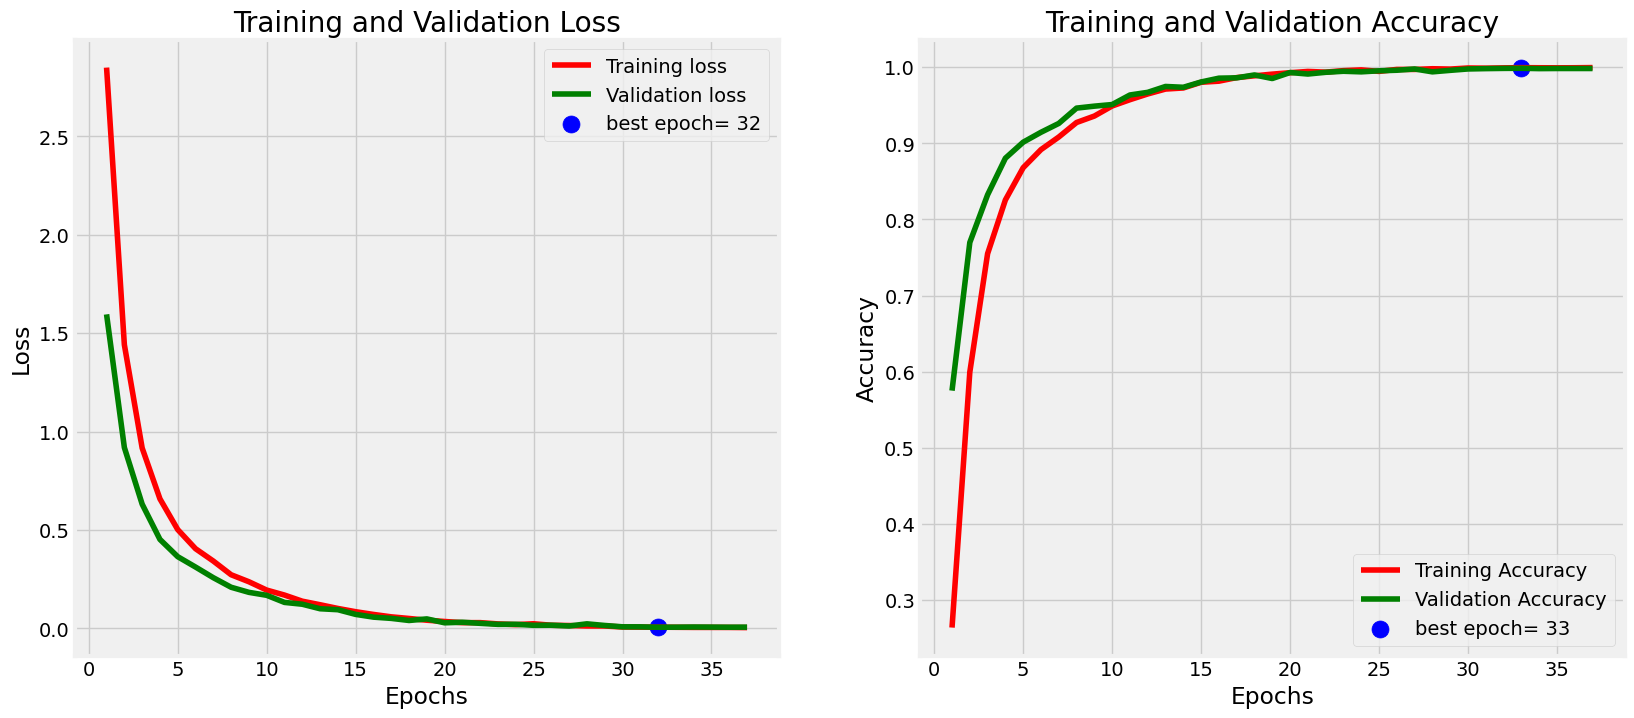

In [16]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# model.evaluate

In [17]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.00674
Test Accuracy: 99.76%


# F1 Score / Recall / Precision

In [23]:
y_true = test_images.classes
y_pred = np.argmax(model.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

207/207 [==============================] - 36s 173ms/step
F1 Score: 0.9975772009678534
                    precision    recall  f1-score   support

           alfalfa       1.00      1.00      1.00       179
            allium       0.99      0.99      0.99       186
            borage       1.00      1.00      1.00       211
           burdock       1.00      1.00      1.00       200
         calendula       1.00      1.00      1.00       201
           cattail       1.00      1.00      1.00       169
         chickweed       1.00      0.99      0.99       207
           chicory       1.00      1.00      1.00       189
     chive_blossom       0.99      1.00      1.00       183
         coltsfoot       1.00      1.00      1.00       204
     common_mallow       1.00      0.99      1.00       170
   common_milkweed       1.00      0.99      1.00       191
      common_vetch       1.00      0.99      1.00       176
     common_yarrow       0.99      1.00      1.00       190
        cone

# Get Predictions

In [ ]:
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))),
                            "Test Labels" : test_images.labels,
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_images.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(test_images), axis = 1))]
                           })
Predictions.head(8)

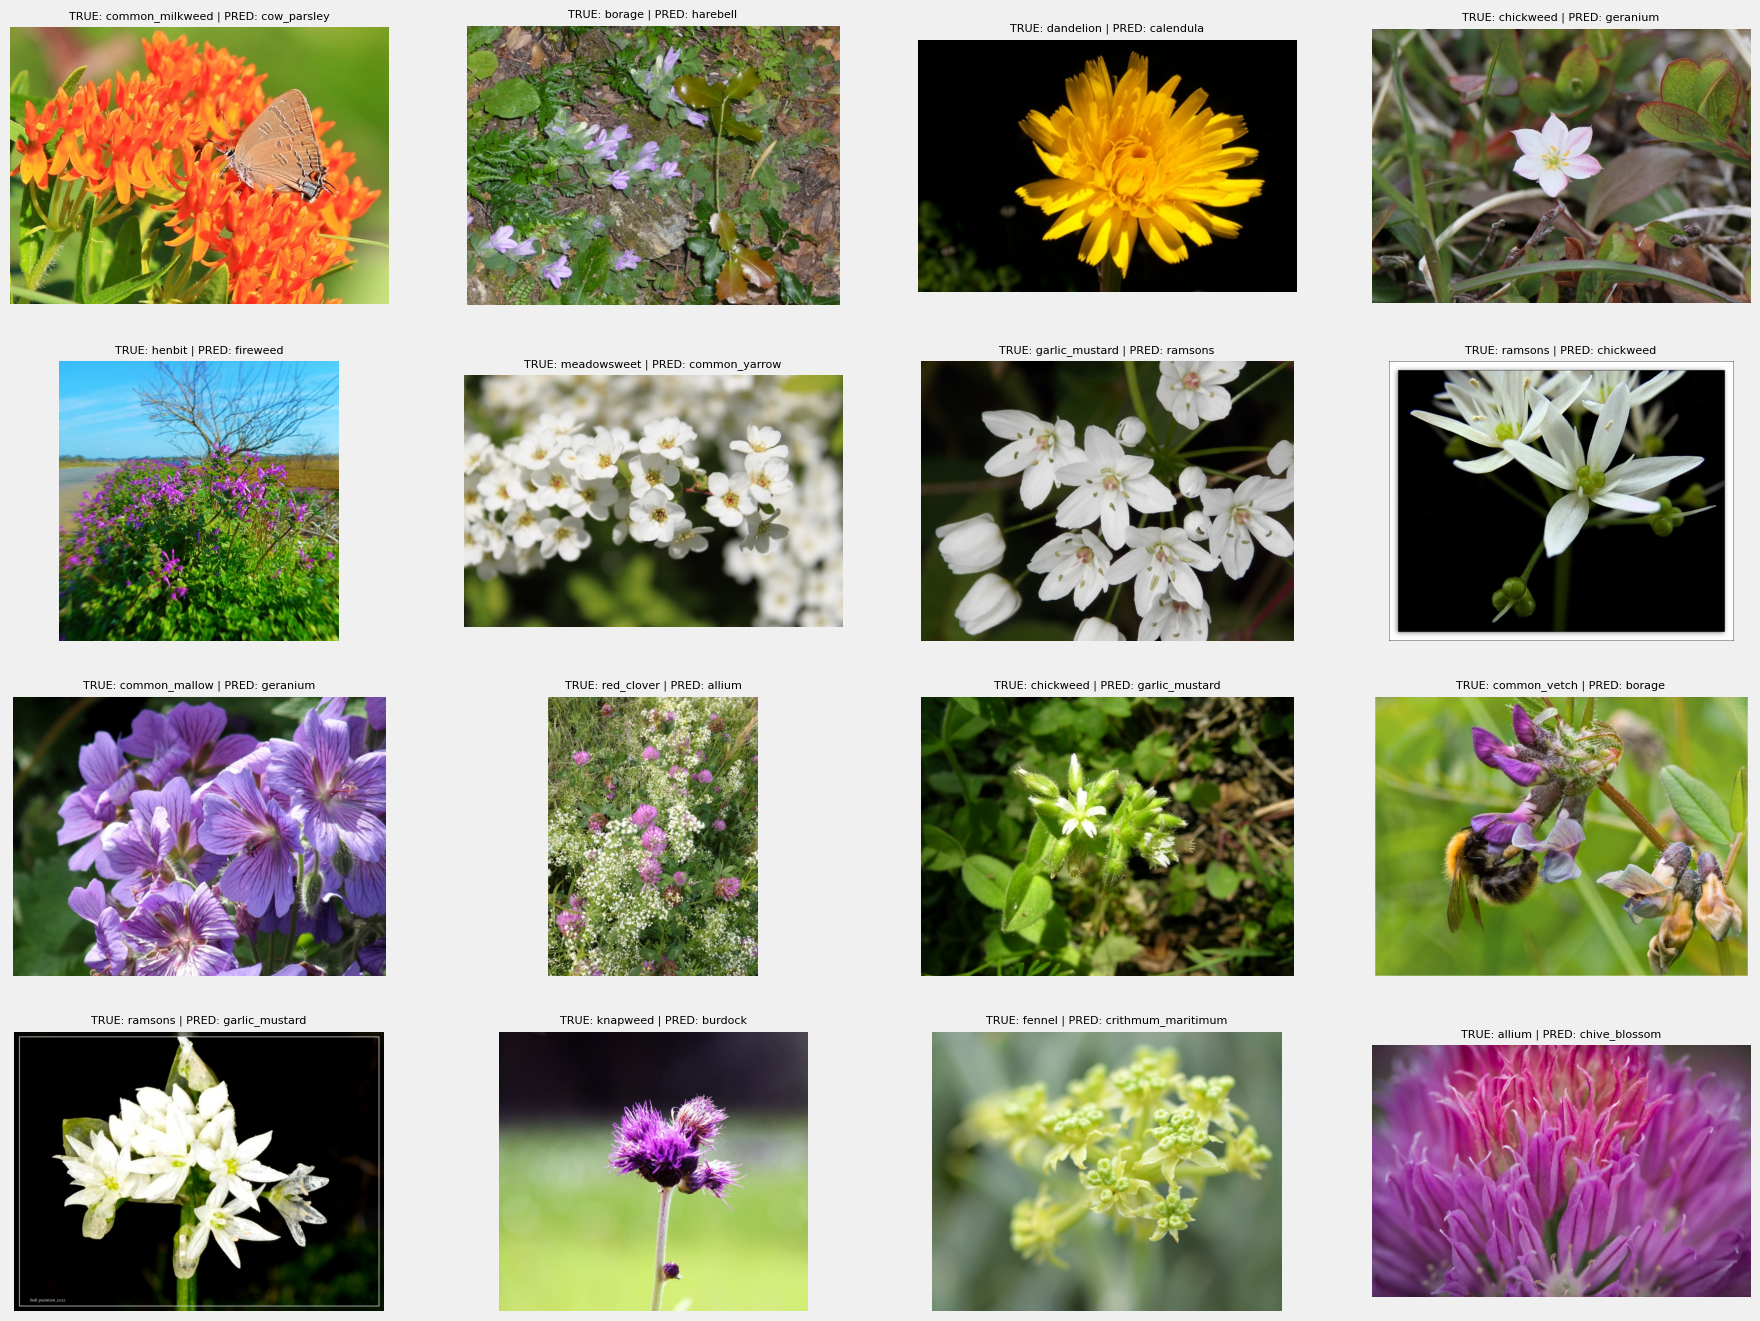

In [20]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')

plt.show()

# Print the most confident errors

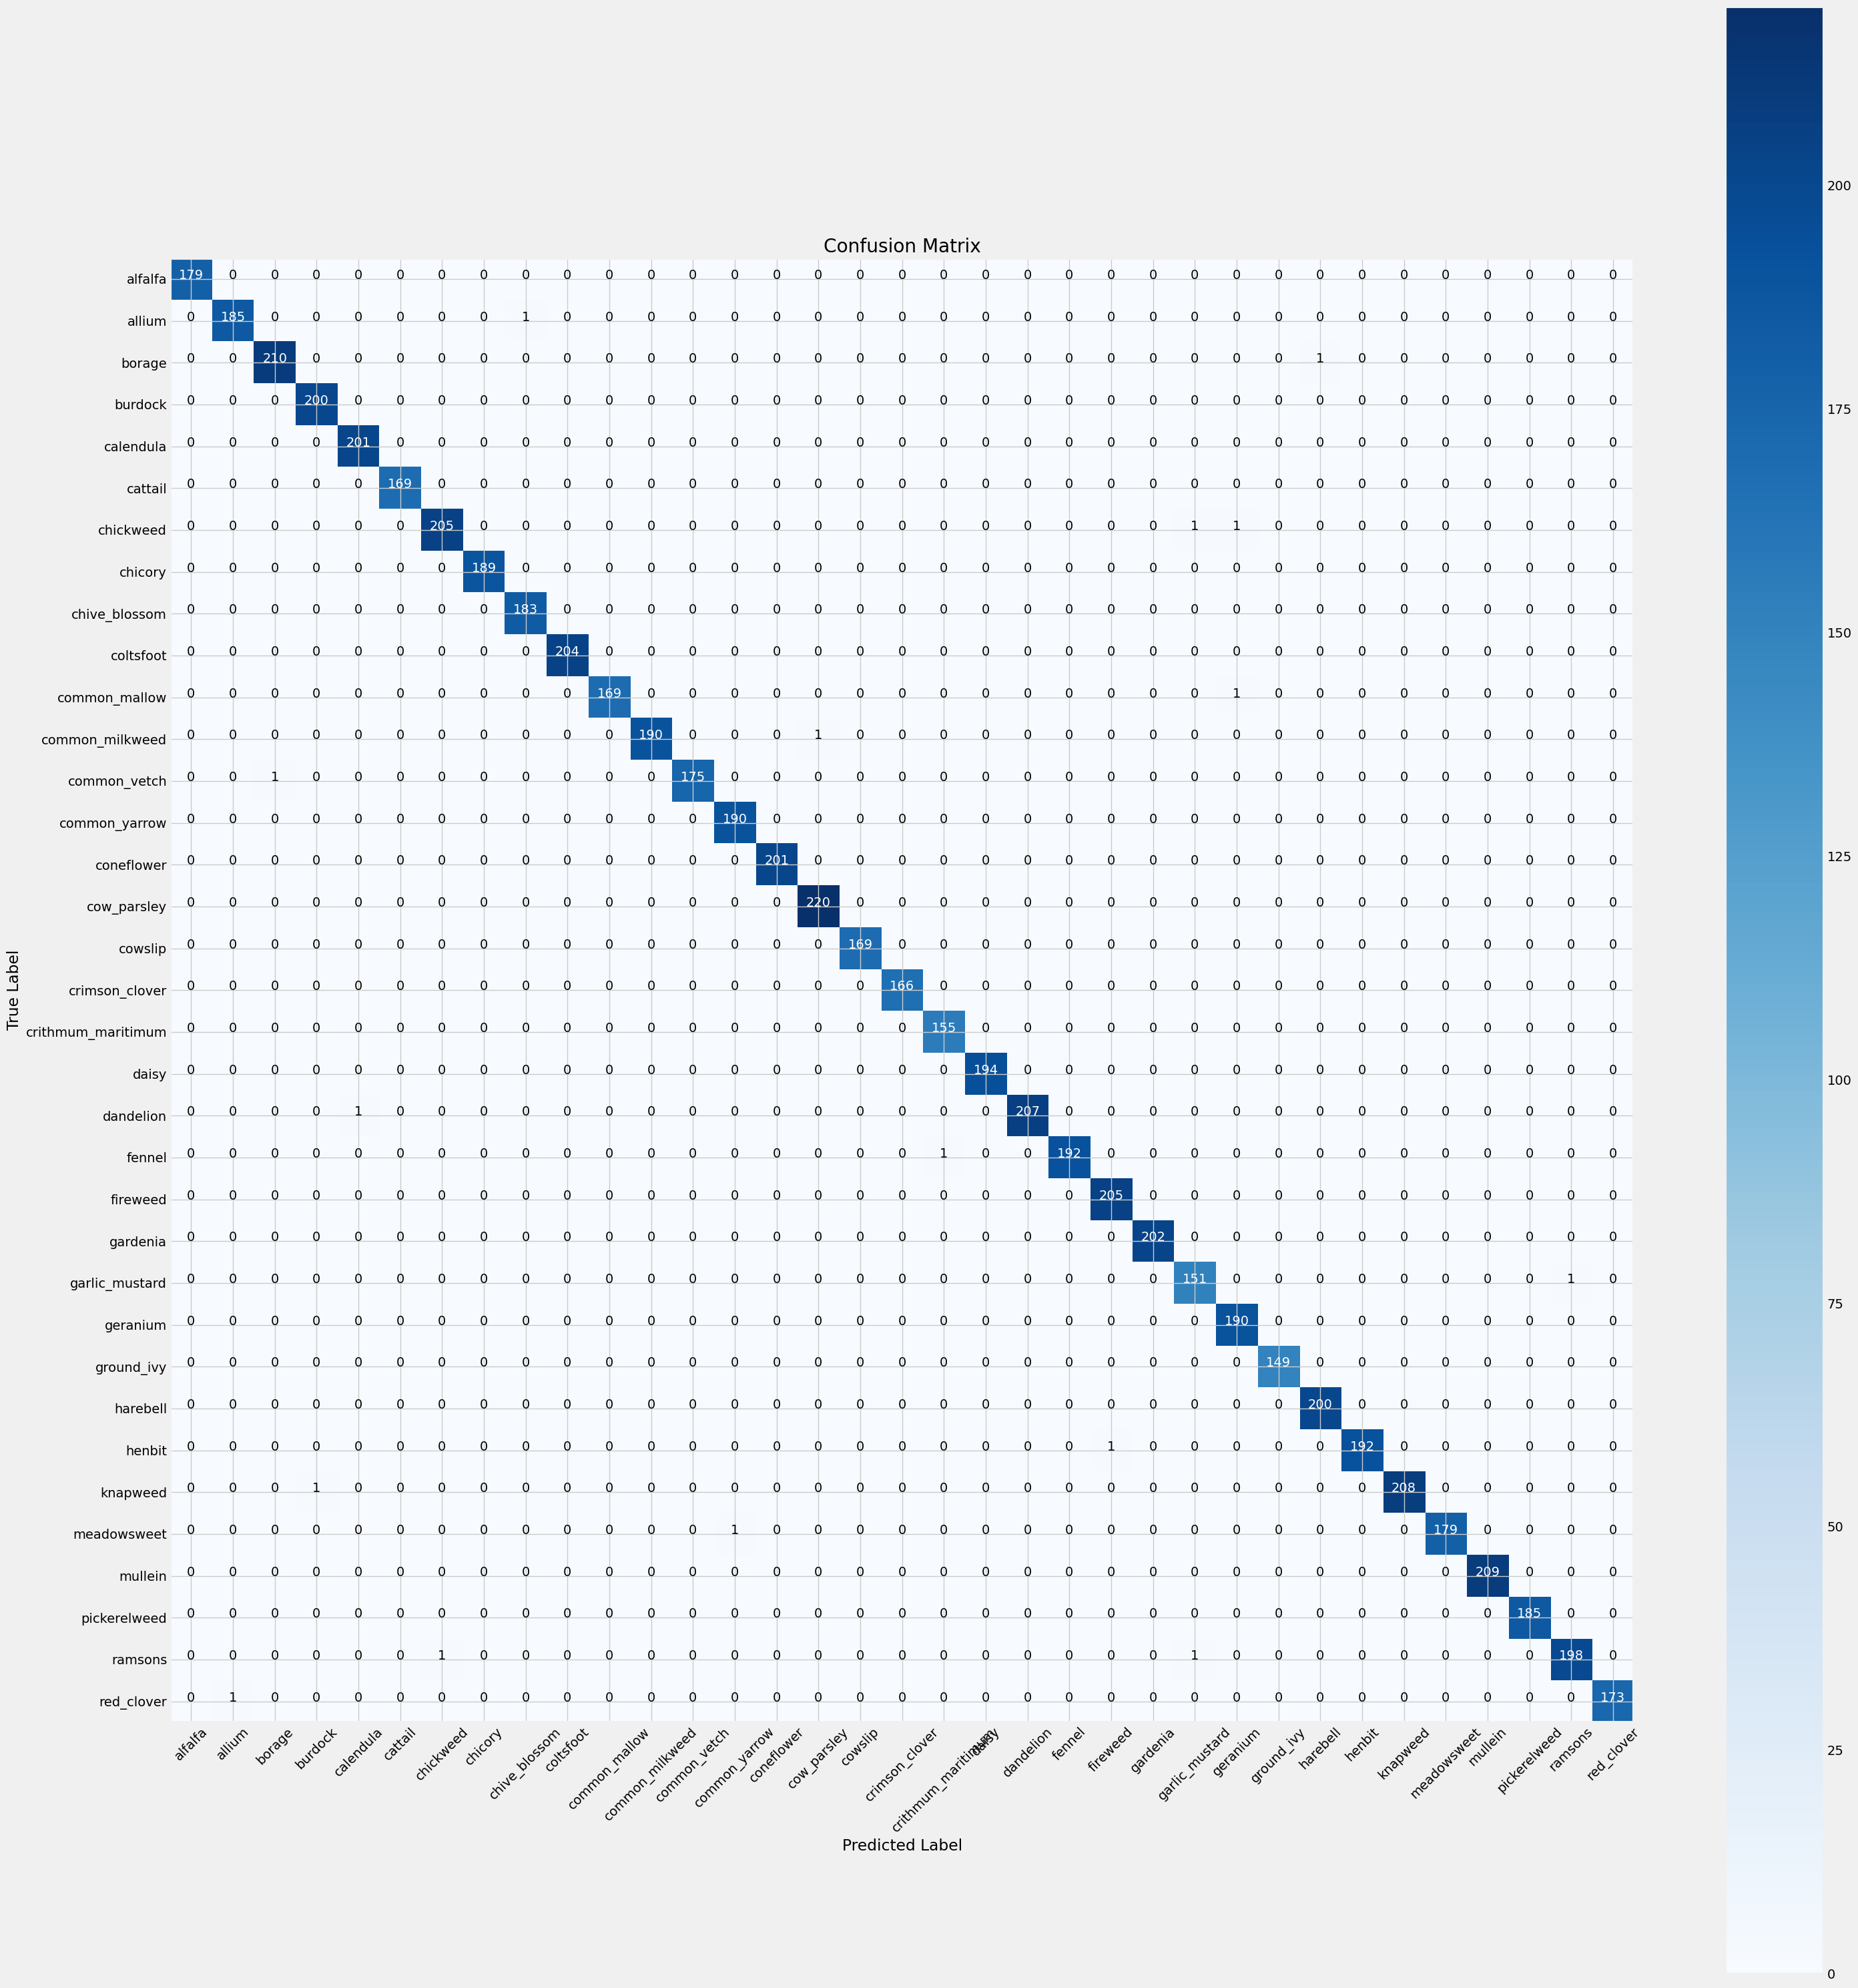

In [24]:
preds = model.predict_generator(test_images)
y_pred = np.argmax(preds, axis=1)
g_dict = test_images.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_images.classes, y_pred)

plt.figure(figsize= (30, 30))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [25]:
model.save("EdibleWildPlantsEfficientNetB5.h5")